In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.regularizers import l2

In [3]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
batch_size = 32
img_size = [180,180]

In [6]:
#training Dataset
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.2 ,subset='training',shuffle=True,
                                                     batch_size=batch_size,image_size=img_size,seed=123)

#Validation Dataset
valid_ds=tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset='validation',shuffle=True,
                                                     batch_size=batch_size,image_size=img_size,seed=123)

#Test Dataset for testing the final model
test_t = tf.keras.utils.image_dataset_from_directory(data_dir_test, shuffle=True,batch_size=batch_size,image_size=img_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)
print(test_t.class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


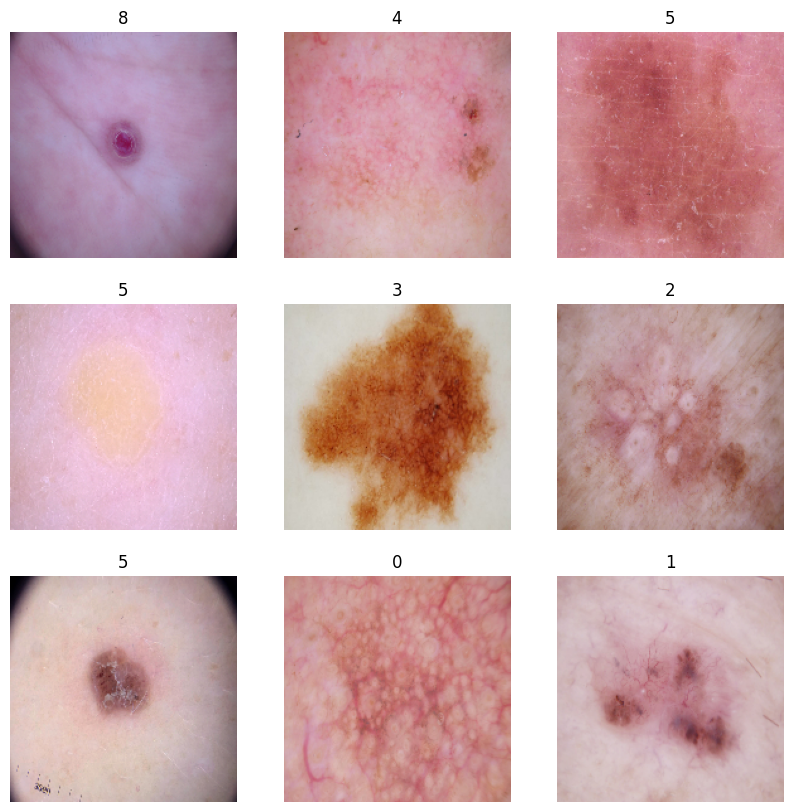

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

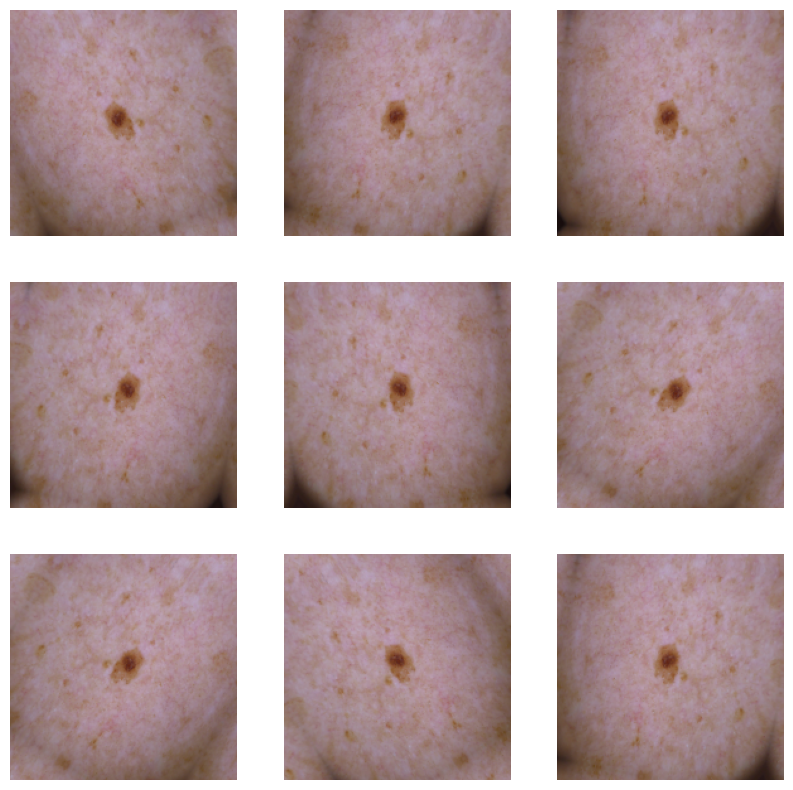

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
test_t = test_t.prefetch(tf.data.AUTOTUNE)

In [13]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

In [14]:
# summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 178, 178, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 64)     256       
 hNormalization)                                      

In [15]:
# compile
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_ds,
              batch_size = 32 ,
              epochs=20,
              validation_data=valid_ds,
              shuffle=True)

Epoch 1/20
56/56 [==============================] - 1258s 22s/step - loss: 27.1618 - accuracy: 0.2478 - val_loss: 31.0649 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 1191s 21s/step - loss: 12.4010 - accuracy: 0.3075 - val_loss: 14.1452 - val_accuracy: 0.1767
Epoch 3/20
56/56 [==============================] - 1193s 21s/step - loss: 11.9705 - accuracy: 0.3594 - val_loss: 12.8557 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 1190s 21s/step - loss: 11.6481 - accuracy: 0.4023 - val_loss: 12.4373 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 1195s 21s/step - loss: 11.3927 - accuracy: 0.4263 - val_loss: 14.2246 - val_accuracy: 0.3468
Epoch 6/20
56/56 [==============================] - 1178s 21s/step - loss: 11.1673 - accuracy: 0.4342 - val_loss: 11.3983 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 1175s 21s/step - loss: 10.8925 - accuracy: 0.4598 - val_loss: 11.4195 - val_ac